# `tundraden` examples

## Generating correlated regressors and target

Let's first generate some random correlated predictors. They are generated using a multivariate normal distribution, so by chosing the covariance matrix we can chose how correlated the regressors are. Here I generate 3 regressors, the 2 first ones being strongly correlated to each other and the third one being uncorrelated to the 2 first ones. The regressors are then pair-plotted:

In [1]:
import tundraden
import numpy as np
import matplotlib.pyplot as plt

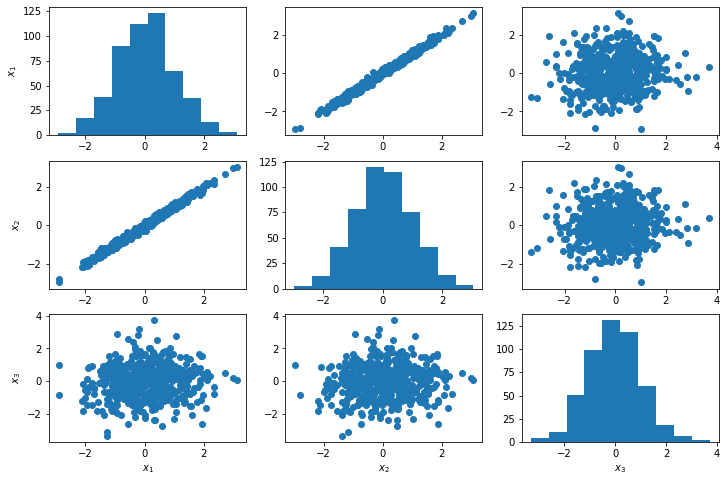

In [2]:
n_samples = 500
covariance_matrix = np.array([
    [1.00, 1.00, 0.00],
    [1.00, 1.01, 0.00],
    [0.00, 0.00, 1.00],
])
X = tundraden.generate_correlated_data(covariance_matrix, n_samples)

plt.figure(figsize=(12,8))
tundraden.pairplot(X, var_names=['$x_1$', '$x_2$', '$x_3$'])
plt.show()

We can clearly see the first two regressors are correlated. The diagonal plots simply show the individual regressors distribution.

Now I generate the target variable using arbitrary weights for each regressor. I also add some extra noise:

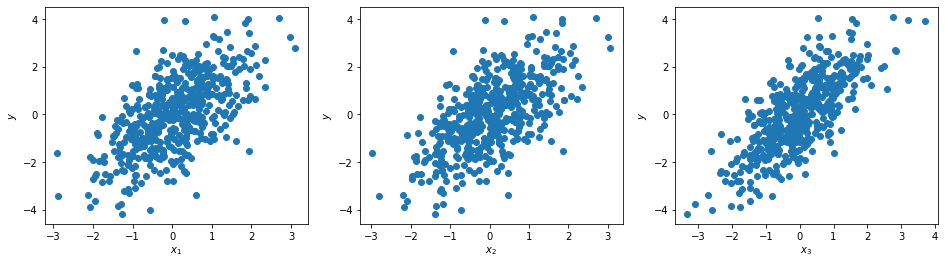

In [3]:
weights = np.array([-1, 2, 1])
sigma = 0.5
Y = tundraden.generate_target(X, weights, sigma)

plt.figure(figsize=(16,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(X[:,i], Y)
    plt.xlabel('$x_%i$'%(i+1))
    plt.ylabel('$y$')
plt.show()

## OLS linear regression

Let's try a simple linear regression:

In [4]:
model = tundraden.LinearRegression()
model.fit(X, Y)
model.coef

array([ 0.0239681 , -1.02999845,  1.94623943,  1.03537636])

As we can see the weights are poorly estimated.

A way of measuring the multicollinearity or the data is to calculate the coefficient of multiple determination and/or the variance inflation factor of each of the predictors:

In [5]:
tundraden.partial_r2(X)

array([0.98939968, 0.98940731, 0.00763915])

In [6]:
tundraden.partial_vif(X)

array([94.33678432, 94.40475297,  1.00769796])

As we can see both the partial coefficients of determination and the variance inflation ratios are high for the first two predictors.

## Ridge regression and hyper-parameter tuning

### Hold-out method

A common way of dealing with multicollinearity is using regularized linear regression, e.g. a Ridge regression. The hyper parameter $\lambda$ defines of strong the regularization is. A naive way to chose the optimal $\lambda$ is to split the data once into a training set and a testing set. The optimal $\lambda$ value is then the one giving the lowest testing error.

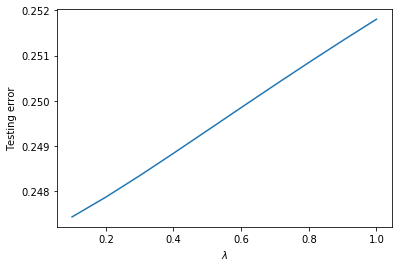

In [7]:
lambdas = np.linspace(0.1, 1.0, 10)

X_train, X_test, Y_train, Y_test = tundraden.train_test_split(X, Y, train_size=0.67)
testing_errors = np.zeros(len(lambdas))
for i, lambda_ in enumerate(lambdas):
    model = tundraden.RidgeRegression(lambda_)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    testing_errors[i] = np.mean((Y_test - Y_pred)**2)
plt.figure()
plt.plot(lambdas, testing_errors)
plt.xlabel('$\lambda$')
plt.ylabel('Testing error')
plt.show()

However is the code snippet below is ran another time, the optimal $\lambda$ found is different, since the split into training and testing sets is done randomly.

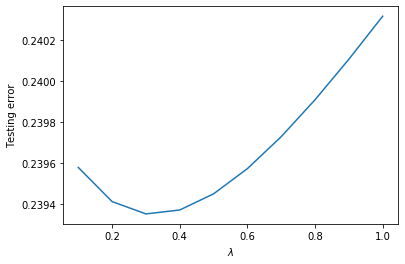

In [8]:
X_train, X_test, Y_train, Y_test = tundraden.train_test_split(X, Y, train_size=0.67)
testing_errors = np.zeros(len(lambdas))
for i, lambda_ in enumerate(lambdas):
    model = tundraden.RidgeRegression(lambda_)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    testing_errors[i] = np.mean((Y_test - Y_pred)**2)
plt.figure()
plt.plot(lambdas, testing_errors)
plt.xlabel('$\lambda$')
plt.ylabel('Testing error')
plt.show()

### K-Fold cross-validation

The usual way of dealing with this is to do cross-validation. Below I do K-fold cross-validation using 10 folds.

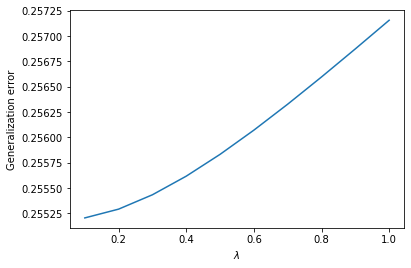

In [9]:
n_folds = 10
test_errors = np.zeros((n_folds, len(lambdas)))
for i, (train_index, test_index) in enumerate(tundraden.kfold_split(X, n_folds)):
    X_train = X[train_index]
    X_test = X[test_index]
    Y_train = Y[train_index]
    Y_test = Y[test_index]
    for j, lambda_ in enumerate(lambdas):
        model = tundraden.RidgeRegression(lambda_)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        test_errors[i, j] = np.mean((Y_test - Y_pred)**2)
generalization_errors = test_errors.mean(axis=0)
plt.figure()
plt.plot(lambdas, generalization_errors)
plt.xlabel('$\lambda$')
plt.ylabel('Generalization error')
plt.show()

### Leave-one-out cross-validation

I can also do leave-one-out cross-validation:

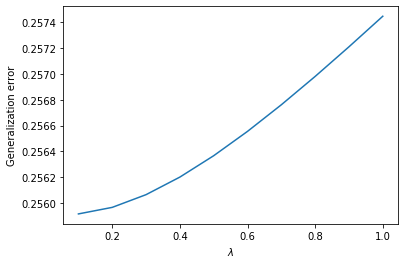

In [10]:
test_errors = np.zeros((len(X), len(lambdas)))
for i, (train_index, test_index) in enumerate(tundraden.leave_one_out_split(X)):
    X_train = X[train_index]
    X_test = X[test_index]
    Y_train = Y[train_index]
    Y_test = Y[test_index]
    np.hstack((np.ones((X_test.shape[0], 1)), X_test))
    for j, lambda_ in enumerate(lambdas):
        model = tundraden.RidgeRegression(lambda_)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        test_errors[i, j] = np.mean((Y_test - Y_pred)**2)
generalization_errors = test_errors.mean(axis=0)
plt.figure()
plt.plot(lambdas, generalization_errors)
plt.xlabel('$\lambda$')
plt.ylabel('Generalization error')
plt.show()